In [1]:
debug = False

In [2]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import math
import collections
import time
from copy import deepcopy
import seaborn as sns
import os, gc
from tqdm import tqdm
import re

from statsmodels.graphics.tsaplots import plot_acf


from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, confusion_matrix, accuracy_score, mean_squared_error, roc_auc_score, roc_curve
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

from collections import Counter, defaultdict

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import joblib

pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 100)

In [3]:
import polars as pl

def timestamp_UTC_conversion(train, date_col) :
    """  """
    
    if date_col == 'date' :
        train = train.rename(columns = {'date' : 'date_'})
        date_col = 'date_'
            
    dt_transforms = [
                     (pl.col(date_col).str.to_datetime().dt.date()).alias('date'),
                     pl.col(date_col).str.to_datetime().dt.time().alias('time'),
                    ]

    return  (pl.from_pandas(train)
               .with_columns((dt_transforms))
               .to_pandas()
            )

In [4]:
def process_date(train, date_col, prefixe = '', extract_features = False) :

    train[date_col] = train[date_col].astype(str)

    train = timestamp_UTC_conversion(train, date_col)
    
    train['date'] = train['date'].astype(str)
    train['time'] = train['time'].astype(str)
    train[date_col] = train['date'] + ' ' + train['time']
    
    if not(extract_features) :
        return train

    train['year']  = (train['date'].apply(lambda x : x[:4]).astype(int)).astype(int)
    train['month'] = train['date'].apply(lambda x : x[5:7]).astype(int)
    train['day']   = train['date'].apply(lambda x : x[8:10]).astype(int)
    

    train['dayofweek'] = train[['year', 'month', 'day']].apply(lambda row : datetime(row['year'], row['month'], row['day']).weekday(), axis=1)
    

    train['hour']    = train['time'].apply(lambda x : x[:2]).astype(int)
    train['minutes'] = train['time'].apply(lambda x : x[3:5]).astype(int)
    train['seconds'] = train['time'].apply(lambda x : x[6:7]).astype(int)

    if len(prefixe) > 0 :
        cols = ['year', 'month', 'day', 'hour', 'minutes', 'seconds']
        train = train.rename(columns = {k : f"{prefixe}_{k}" for k in cols})


    return train

In [5]:
def reduce_memory_usage(df, print_info=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    
    if print_info :
        print('*'*50)
        start_mem = df.memory_usage().sum() / 1024**2
        print('Memory before : {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    if print_info :
        end_mem = df.memory_usage().sum() / 1024**2
        print('Memory after  : {:.2f} MB'.format(end_mem))
        print('Decreased by  : {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        print('*'*50 + '\n')
    
    return df

In [6]:
train = pd.read_csv("predict-energy-behavior-of-prosumers/train.csv")
if debug :
    print("DEBUG IS ON !")
    train = train.sample(n=n_rows_debug, random_state=12)

print(train.shape)
train.head(2)

(2018352, 9)


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.71300,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.59000,1,2021-09-01 00:00:00,0,1,0


In [7]:
pivot_train = train.pivot_table(index='datetime',columns=['county','product_type','is_business','is_consumption'], values='target', aggfunc='mean')

pivot_train.columns = ['county{}_productType{}_isBusiness{}_isConsumption{}'.format(*col) for col in pivot_train.columns.values]
pivot_train.index = pd.to_datetime(pivot_train.index)
pivot_train.head(2)

,county0_productType0_isBusiness1_isConsumption0,county0_productType0_isBusiness1_isConsumption1,county0_productType1_isBusiness0_isConsumption0,county0_productType1_isBusiness0_isConsumption1,county0_productType1_isBusiness1_isConsumption0,county0_productType1_isBusiness1_isConsumption1,county0_productType2_isBusiness0_isConsumption0,county0_productType2_isBusiness0_isConsumption1,county0_productType2_isBusiness1_isConsumption0,county0_productType2_isBusiness1_isConsumption1,county0_productType3_isBusiness0_isConsumption0,county0_productType3_isBusiness0_isConsumption1,county0_productType3_isBusiness1_isConsumption0,county0_productType3_isBusiness1_isConsumption1,county1_productType1_isBusiness0_isConsumption0,county1_productType1_isBusiness0_isConsumption1,county1_productType3_isBusiness0_isConsumption0,county1_productType3_isBusiness0_isConsumption1,county1_productType3_isBusiness1_isConsumption0,county1_productType3_isBusiness1_isConsumption1,county2_productType1_isBusiness0_isConsumption0,county2_productType1_isBusiness0_isConsumption1,county2_productType1_isBusiness1_isConsumption0,county2_productType1_isBusiness1_isConsumption1,county2_productType3_isBusiness0_isConsumption0,county2_productType3_isBusiness0_isConsumption1,county2_productType3_isBusiness1_isConsumption0,county2_productType3_isBusiness1_isConsumption1,county3_productType1_isBusiness0_isConsumption0,county3_productType1_isBusiness0_isConsumption1,county3_productType1_isBusiness1_isConsumption0,county3_productType1_isBusiness1_isConsumption1,county3_productType3_isBusiness0_isConsumption0,county3_productType3_isBusiness0_isConsumption1,county3_productType3_isBusiness1_isConsumption0,county3_productType3_isBusiness1_isConsumption1,county4_productType0_isBusiness1_isConsumption0,county4_productType0_isBusiness1_isConsumption1,county4_productType1_isBusiness0_isConsumption0,county4_productType1_isBusiness0_isConsumption1,county4_productType1_isBusiness1_isConsumption0,county4_productType1_isBusiness1_isConsumption1,county4_productType3_isBusiness0_isConsumption0,county4_productType3_isBusiness0_isConsumption1,county4_productType3_isBusiness1_isConsumption0,county4_productType3_isBusiness1_isConsumption1,county5_productType0_isBusiness1_isConsumption0,county5_productType0_isBusiness1_isConsumption1,county5_productType1_isBusiness0_isConsumption0,county5_productType1_isBusiness0_isConsumption1,...,county10_productType2_isBusiness1_isConsumption0,county10_productType2_isBusiness1_isConsumption1,county10_productType3_isBusiness0_isConsumption0,county10_productType3_isBusiness0_isConsumption1,county10_productType3_isBusiness1_isConsumption0,county10_productType3_isBusiness1_isConsumption1,county11_productType0_isBusiness1_isConsumption0,county11_productType0_isBusiness1_isConsumption1,county11_productType1_isBusiness0_isConsumption0,county11_productType1_isBusiness0_isConsumption1,county11_productType1_isBusiness1_isConsumption0,county11_productType1_isBusiness1_isConsumption1,county11_productType2_isBusiness0_isConsumption0,county11_productType2_isBusiness0_isConsumption1,county11_productType2_isBusiness1_isConsumption0,county11_productType2_isBusiness1_isConsumption1,county11_productType3_isBusiness0_isConsumption0,county11_productType3_isBusiness0_isConsumption1,county11_productType3_isBusiness1_isConsumption0,county11_productType3_isBusiness1_isConsumption1,county12_productType3_isBusiness1_isConsumption0,county12_productType3_isBusiness1_isConsumption1,county13_productType1_isBusiness0_isConsumption0,county13_productType1_isBusiness0_isConsumption1,county13_productType1_isBusiness1_isConsumption0,county13_productType1_isBusiness1_isConsumption1,county13_productType3_isBusiness0_isConsumption0,county13_productType3_isBusiness0_isConsumption1,county13_productType3_isBusiness1_isConsumption0,county13_productType3_isBusiness1_isConsumption1,county14_productType1_isBusiness0_isConsumption0,county14_productType1_isBusiness0_isConsumption1,county14_productType1_isBus

<Axes: xlabel='datetime'>

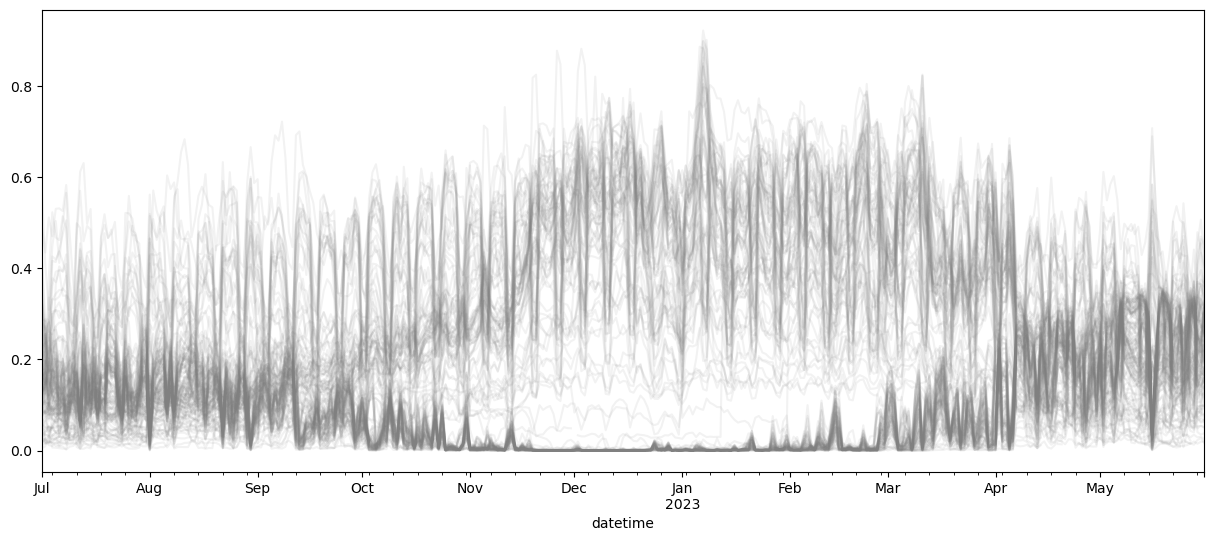

In [8]:
df_plot = pivot_train.copy()
df_plot = (df_plot - df_plot.min())/(df_plot.max() - df_plot.min())
df_plot_resampled_D = df_plot.resample('D').mean()

df_plot_resampled_D.loc['2022-7':].plot(alpha=0.1, color='gray', figsize=(15, 6), legend=False)

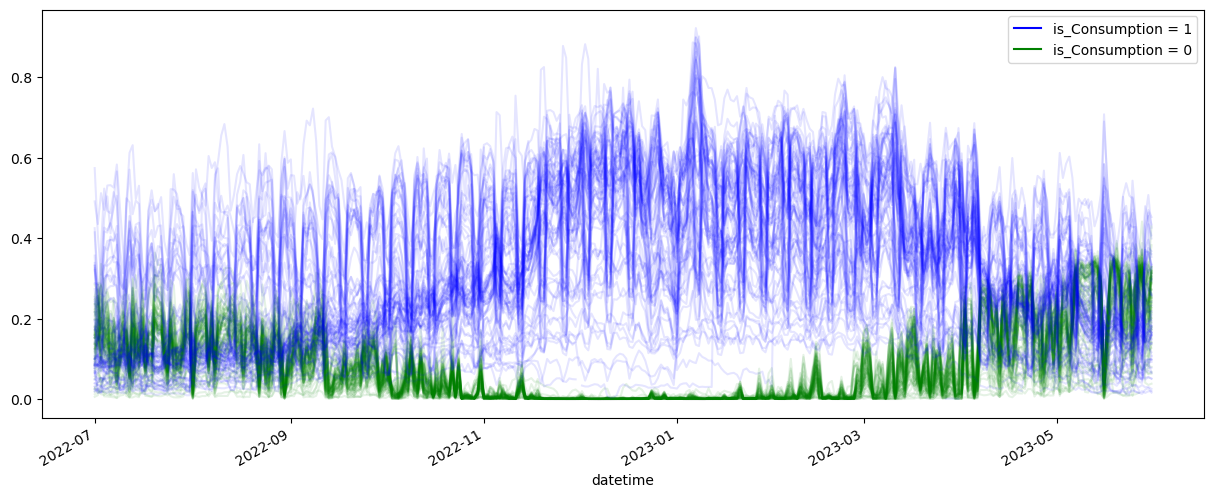

In [9]:
columns_consumption_0 = df_plot_resampled_D.columns[df_plot_resampled_D.columns.str.contains('isConsumption0')]
columns_consumption_1 = df_plot_resampled_D.columns[df_plot_resampled_D.columns.str.contains('isConsumption1')]

plt.figure(figsize=(15, 6))
plt.plot([], color='blue', label='is_Consumption = 1')
plt.plot([], color='green', label='is_Consumption = 0')
plt.legend()

for column in columns_consumption_0:
    df_plot_resampled_D.loc['2022-7':, column].plot(alpha=0.1, color='green', legend=False)

for column in columns_consumption_1:
    df_plot_resampled_D.loc['2022-7':, column].plot(alpha=0.1, color='blue', legend=False)

plt.show()

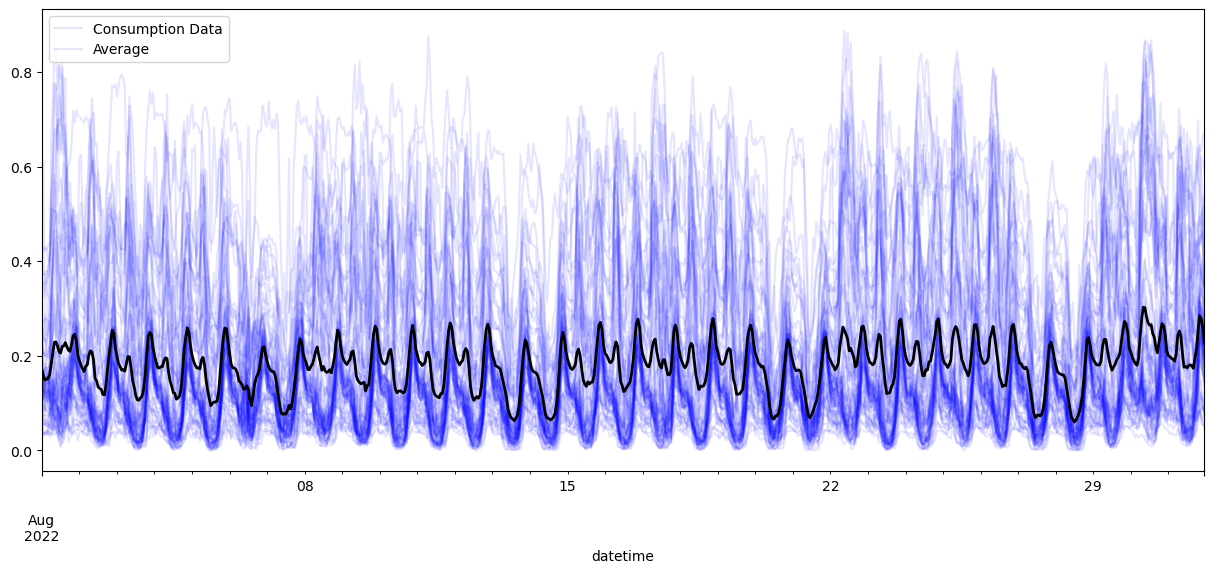

In [10]:
consumption_1 = df_plot.loc[:, df_plot.columns.str.contains('isConsumption1')]

consumption_1_filtered = consumption_1.loc['2022-8']

average_values = consumption_1_filtered.mean(axis=1)

fig, ax = plt.subplots(figsize=(15, 6))

consumption_1_filtered.plot(alpha=0.1, color='blue', ax=ax)

average_values.plot(color='black', linewidth=2, ax=ax)

ax.legend(['Consumption Data', 'Average'])

plt.show()

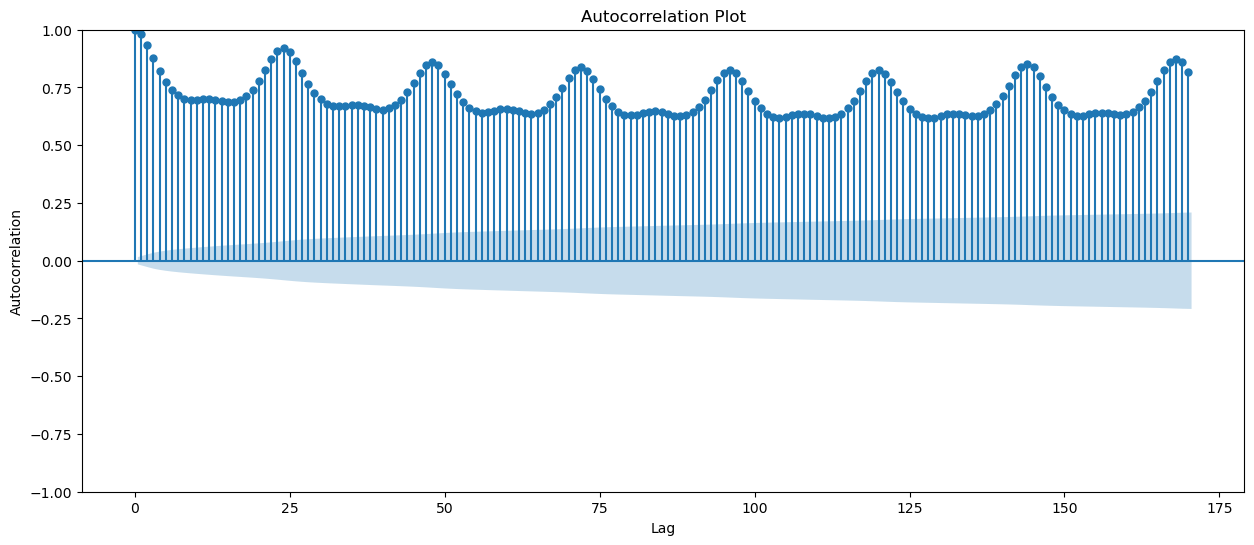

In [11]:
average_values = consumption_1.mean(axis=1)

fig, ax = plt.subplots(figsize=(15, 6))

plot_acf(average_values, lags=170, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot')
plt.show()

In [12]:
%%time

for date_col in ['datetime'] :
    train = process_date(train, date_col, extract_features = True)

print(train.shape)
train.head(2)

(2018352, 18)
CPU times: total: 27 s
Wall time: 26.7 s


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,month,day,dayofweek,hour,minutes,seconds
0,0,0,1,0.71300,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0
1,0,0,1,96.59000,1,2021-09-01 00:00:00,0,1,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0


In [13]:
train['datetime'].value_counts().to_frame().sort_index()

,datetime
2021-09-01 00:00:00,122
2021-09-01 01:00:00,122
2021-09-01 02:00:00,122
2021-09-01 03:00:00,122
2021-09-01 04:00:00,122
...,...
2023-05-31 19:00:00,130
2023-05-31 20:00:00,130
2023-05-31 21:00:00,130
2023-05-31 22:00:00,130


count   2017824.00000
mean        274.85556
std         909.50238
min           0.00000
25%           0.37800
50%          31.13300
75%         180.20625
max       15480.27400
Name: target, dtype: float64

<Axes: >

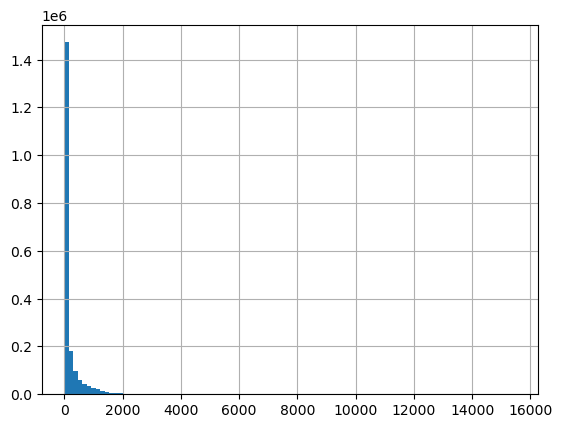

In [14]:
display(train['target'].describe())
train['target'].hist(bins=100)

In [15]:
for day_shift in range(2, 8) :

    train['data_block_id_shifted'] = train['data_block_id'] + day_shift
    train = pd.merge(train,
                     train[["county", "is_business", "product_type", "is_consumption", "time", "data_block_id_shifted", "target"]].rename(columns = {"data_block_id_shifted":"data_block_id",
                                                                                                                                                     "target" : f"target_revealed_{day_shift}days_ago",
                                                                                                                                                    }),
                     how = 'left',
                     on = ["county", "is_business", "product_type", "is_consumption", "time", "data_block_id"],
                    )

    mask = train[f"target_revealed_{day_shift}days_ago"].isna()
    train.loc[mask, f"target_revealed_{day_shift}days_ago"] = train.loc[mask, "target"]

train.drop(columns = ['data_block_id_shifted'], inplace=True)

print(train.shape)
train.tail(2)

(2018352, 24)


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago
2018350,15,1,3,0.00000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-31,23:00:00,2023,5,31,2,23,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2018351,15,1,3,196.24000,1,2023-05-31 23:00:00,637,2018351,60,2023-05-31,23:00:00,2023,5,31,2,23,0,0,177.05600,161.65000,183.75600,189.93300,188.68900,195.70700


In [16]:
county = 15
is_business = 1
product_type = 3
is_consumption = 1

In [17]:
df = train.copy()

print(df.shape)
df.head(2)

(2018352, 24)


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago
0,0,0,1,0.71300,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300
1,0,0,1,96.59000,1,2021-09-01 00:00:00,0,1,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000


In [18]:
electricity_prices = pd.read_csv("predict-energy-behavior-of-prosumers/electricity_prices.csv")

for date_col in ['forecast_date', 'origin_date'] :
    electricity_prices = process_date(electricity_prices, date_col)

print(electricity_prices.shape)
electricity_prices.head(2)

(15286, 6)


,forecast_date,euros_per_mwh,origin_date,data_block_id,date,time
0,2021-09-01 00:00:00,92.51000,2021-08-31 00:00:00,1,2021-08-31,00:00:00
1,2021-09-01 01:00:00,88.90000,2021-08-31 01:00:00,1,2021-08-31,01:00:00


In [19]:
%%time

electricity_prices['data_block_id_shifted'] = electricity_prices['data_block_id'] + 2

df = pd.merge(df,
              electricity_prices[["time", "data_block_id_shifted", "euros_per_mwh"]].rename(columns = {"data_block_id_shifted":"data_block_id"}),
              how = 'left',
              on = ["time", "data_block_id"],
             )

print(df.shape)
df.head(2)

(2018352, 25)
CPU times: total: 750 ms
Wall time: 753 ms


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,euros_per_mwh
0,0,0,1,0.71300,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,NaN
1,0,0,1,96.59000,1,2021-09-01 00:00:00,0,1,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,NaN


In [20]:
gas_prices = pd.read_csv("predict-energy-behavior-of-prosumers/gas_prices.csv")

for date_col in ['forecast_date', 'origin_date'] :
    gas_prices = process_date(gas_prices, date_col)

print(gas_prices.shape)
gas_prices.head(2)

(637, 7)


,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id,date,time
0,2021-09-01 00:00:00,45.23000,46.32000,2021-08-31 00:00:00,1,2021-08-31,00:00:00
1,2021-09-02 00:00:00,45.62000,46.29000,2021-09-01 00:00:00,2,2021-09-01,00:00:00


In [21]:
%%time

gas_prices['data_block_id_shifted'] = gas_prices['data_block_id'] + 2

cols = ['data_block_id_shifted', 'time', 'lowest_price_per_mwh', 'highest_price_per_mwh']
df = df.merge(gas_prices[cols].rename(columns = {'data_block_id_shifted' : 'data_block_id'}),
             how='left',
             on=["time", "data_block_id"],
             )

print(df.shape)
df.head(2)

(2018352, 27)
CPU times: total: 703 ms
Wall time: 697 ms


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh
0,0,0,1,0.71300,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,NaN,NaN,NaN
1,0,0,1,96.59000,1,2021-09-01 00:00:00,0,1,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,NaN,NaN,NaN


In [22]:
gas_prices = pd.read_csv("predict-energy-behavior-of-prosumers/gas_prices.csv")

for date_col in ['forecast_date', 'origin_date'] :
    gas_prices = process_date(gas_prices, date_col)
    
print(gas_prices.shape)
gas_prices.head(2)

(637, 7)


,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id,date,time
0,2021-09-01 00:00:00,45.23000,46.32000,2021-08-31 00:00:00,1,2021-08-31,00:00:00
1,2021-09-02 00:00:00,45.62000,46.29000,2021-09-01 00:00:00,2,2021-09-01,00:00:00


In [23]:
%%time

gas_prices['data_block_id_shifted'] = gas_prices['data_block_id'] + 2

cols = ['data_block_id_shifted', 'time', 'lowest_price_per_mwh', 'highest_price_per_mwh']
df = df.merge(gas_prices[cols].rename(columns = {'data_block_id_shifted' : 'data_block_id'}),
             how='left',
             on=["time", "data_block_id"],
             )

print(df.shape)
df.head(2)

(2018352, 29)
CPU times: total: 797 ms
Wall time: 791 ms


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,euros_per_mwh,lowest_price_per_mwh_x,highest_price_per_mwh_x,lowest_price_per_mwh_y,highest_price_per_mwh_y
0,0,0,1,0.71300,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.59000,1,2021-09-01 00:00:00,0,1,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,NaN,NaN,NaN,NaN,NaN


In [24]:
client = pd.read_csv("predict-energy-behavior-of-prosumers/client.csv")

client = client.rename(columns = {'date' : 'datetime'})

for date_col in ['datetime'] :
    client = process_date(client, date_col)
    
client.fillna(0, inplace=True)

print(client.shape)
client.head(2)

(41919, 9)


,product_type,county,eic_count,installed_capacity,is_business,datetime,data_block_id,date,time
0,1,0,108,952.89000,0,2021-09-01 00:00:00,2,2021-09-01,00:00:00
1,2,0,17,166.40000,0,2021-09-01 00:00:00,2,2021-09-01,00:00:00


In [25]:
%%time

client['data_block_id_shifted'] = client['data_block_id'] + 2

df = df.merge(client.drop(columns = ['date', 'datetime', 'data_block_id', 'time']).rename(columns = {'data_block_id_shifted' : 'data_block_id'}),
             how='left',
             on=['data_block_id', 'county', 'is_business', 'product_type'],
             )

print(df.shape)
df.head(2)

(2018352, 31)
CPU times: total: 781 ms
Wall time: 781 ms


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,euros_per_mwh,lowest_price_per_mwh_x,highest_price_per_mwh_x,lowest_price_per_mwh_y,highest_price_per_mwh_y,eic_count,installed_capacity
0,0,0,1,0.71300,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.59000,1,2021-09-01 00:00:00,0,1,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
location = pd.read_csv("fabiendaniels-mapping-locations-and-county-code/county_lon_lats.csv").drop(columns = ["Unnamed: 0"])

for k in ['latitude', 'longitude'] :
    location[k] = (10*location[k]).astype(int)

print(location.shape)
location.head(2)

(75, 3)


,county,longitude,latitude
0,0,242,591
1,0,252,591


In [27]:
def process_weather_info(h, location=location) :
    
    h = h.drop_duplicates().reset_index(drop=True)

    for k in ['latitude', 'longitude'] :
        h[k] = (10*h[k]).astype(int)
    
    h = pd.merge(h, location, how='left', on=['latitude', 'longitude'])
    
    h['county'] = h['county'].fillna(-1).astype(int)

    return h

In [28]:
%%time

historical_weather = pd.read_csv("predict-energy-behavior-of-prosumers/historical_weather.csv")

for date_col in ['datetime'] :
    historical_weather = process_date(historical_weather, date_col)

print(historical_weather.shape)
historical_weather.head(2)

(1710800, 20)
CPU times: total: 5.53 s
Wall time: 5.06 s


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,date,time
0,2021-09-01 00:00:00,14.40000,12.00000,0.00000,0.00000,1015.80000,4,4,0,0,6.69444,3,0.00000,0.00000,0.00000,57.60000,21.70000,1,2021-09-01,00:00:00
1,2021-09-01 00:00:00,14.40000,12.00000,0.00000,0.00000,1015.80000,4,4,0,0,6.69444,3,0.00000,0.00000,0.00000,57.60000,21.70000,1,2021-09-01,00:00:00


In [29]:
historical_weather = process_weather_info(historical_weather)

print(historical_weather.shape)
historical_weather.head(2)

(1680250, 21)


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,date,time,county
0,2021-09-01 00:00:00,14.40000,12.00000,0.00000,0.00000,1015.80000,4,4,0,0,6.69444,3,0.00000,0.00000,0.00000,576,217,1,2021-09-01,00:00:00,-1
1,2021-09-01 00:00:00,14.00000,12.00000,0.00000,0.00000,1010.60000,7,8,0,0,4.94444,353,0.00000,0.00000,0.00000,576,222,1,2021-09-01,00:00:00,-1


In [30]:
dict_agg = {'temperature' : ['min', 'mean', 'max', 'std'],
            'dewpoint' : ['min', 'mean', 'max', 'std'],
            'rain' : ['min', 'mean', 'max', 'std'],
            'snowfall' : ['min', 'mean', 'max', 'std'],
            'surface_pressure' : ['min', 'mean', 'max', 'std'],
            'cloudcover_total' : ['min', 'mean', 'max', 'std'],
            'cloudcover_low' : ['min', 'mean', 'max', 'std'],
            'cloudcover_mid' : ['min', 'mean', 'max', 'std'],
            'cloudcover_high' : ['min', 'mean', 'max', 'std'],
            'windspeed_10m' : ['min', 'mean', 'max', 'std'],
            'winddirection_10m' : ['min', 'mean', 'max', 'std'],
            'shortwave_radiation' : ['min', 'mean', 'max', 'std'],
            'direct_solar_radiation' : ['min', 'mean', 'max', 'std'],
            'diffuse_radiation' : ['min', 'mean', 'max', 'std'],
           }

keys = ['county', 'datetime']
historical_weather = historical_weather.groupby(keys).agg(dict_agg).reset_index()

historical_weather.columns = ['_'.join([xx for xx in x if len(xx)>0]) for x in historical_weather.columns]
historical_weather.columns = [x + '_h' if x not in keys else x for x in historical_weather.columns]

print(historical_weather.shape)
historical_weather.head(2)

(244400, 58)


,county,datetime,temperature_min_h,temperature_mean_h,temperature_max_h,temperature_std_h,dewpoint_min_h,dewpoint_mean_h,dewpoint_max_h,dewpoint_std_h,rain_min_h,rain_mean_h,rain_max_h,rain_std_h,snowfall_min_h,snowfall_mean_h,snowfall_max_h,snowfall_std_h,surface_pressure_min_h,surface_pressure_mean_h,surface_pressure_max_h,surface_pressure_std_h,cloudcover_total_min_h,cloudcover_total_mean_h,cloudcover_total_max_h,cloudcover_total_std_h,cloudcover_low_min_h,cloudcover_low_mean_h,cloudcover_low_max_h,cloudcover_low_std_h,cloudcover_mid_min_h,cloudcover_mid_mean_h,cloudcover_mid_max_h,cloudcover_mid_std_h,cloudcover_high_min_h,cloudcover_high_mean_h,cloudcover_high_max_h,cloudcover_high_std_h,windspeed_10m_min_h,windspeed_10m_mean_h,windspeed_10m_max_h,windspeed_10m_std_h,winddirection_10m_min_h,winddirection_10m_mean_h,winddirection_10m_max_h,winddirection_10m_std_h,shortwave_radiation_min_h,shortwave_radiation_mean_h,shortwave_radiation_max_h,shortwave_radiation_std_h,direct_solar_radiation_min_h,direct_solar_radiation_mean_h,direct_solar_radiation_max_h,direct_solar_radiation_std_h,diffuse_radiation_min_h,diffuse_radiation_mean_h,diffuse_radiation_max_h,diffuse_radiation_std_h
0,-1,2021-09-01 00:00:00,12.20000,13.96667,15.90000,0.95349,9.80000,11.51944,12.80000,0.73478,0.00000,0.05278,0.90000,0.19926,0.00000,0.00000,0.00000,0.00000,995.90000,1009.62222,1016.50000,5.59291,3,41.33333,100,39.98142,0,33.55556,100,38.91635,0,7.22222,96,22.42589,0,46.38889,100,40.85464,2.36111,5.25540,11.13889,2.52370,1,267.66667,360,144.08490,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,-1,2021-09-01 01:00:00,11.70000,13.65000,15.70000,1.14180,9.40000,11.38611,12.90000,0.82985,0.00000,0.03889,0.80000,0.16437,0.00000,0.00000,0.00000,0.00000,996.00000,1009.77500,1016.80000,5.64130,1,43.61111,100,34.79842,0,35.22222,100,32.06878,0,7.61111,99,22.48463,0,41.94444,100,40.61382,2.50000,5.36265,10.75000,2.22765,2,316.05556,360,96.57416,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [31]:
%%time

historical_weather['datetime_shifted'] = (pd.to_datetime(historical_weather['datetime'].astype(str)) + pd.Timedelta(days=1, hours=13)).astype(str)

df = df.merge(historical_weather.drop(columns = ['datetime']).rename(columns = {'datetime_shifted' : 'datetime'}),
              how='left',
              on=['county', 'datetime'],
             )

print(df.shape)
df.head(2)

(2018352, 87)
CPU times: total: 2.09 s
Wall time: 2.11 s


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,euros_per_mwh,lowest_price_per_mwh_x,highest_price_per_mwh_x,lowest_price_per_mwh_y,highest_price_per_mwh_y,eic_count,installed_capacity,temperature_min_h,temperature_mean_h,temperature_max_h,temperature_std_h,dewpoint_min_h,dewpoint_mean_h,dewpoint_max_h,dewpoint_std_h,rain_min_h,rain_mean_h,rain_max_h,rain_std_h,snowfall_min_h,snowfall_mean_h,snowfall_max_h,snowfall_std_h,surface_pressure_min_h,surface_pressure_mean_h,surface_pressure_max_h,surface_pressure_std_h,cloudcover_total_min_h,cloudcover_total_mean_h,cloudcover_total_max_h,cloudcover_total_std_h,cloudcover_low_min_h,cloudcover_low_mean_h,cloudcover_low_max_h,cloudcover_low_std_h,cloudcover_mid_min_h,cloudcover_mid_mean_h,cloudcover_mid_max_h,cloudcover_mid_std_h,cloudcover_high_min_h,cloudcover_high_mean_h,cloudcover_high_max_h,cloudcover_high_std_h,windspeed_10m_min_h,windspeed_10m_mean_h,windspeed_10m_max_h,windspeed_10m_std_h,winddirection_10m_min_h,winddirection_10m_mean_h,winddirection_10m_max_h,winddirection_10m_std_h,shortwave_radiation_min_h,shortwave_radiation_mean_h,shortwave_radiation_max_h,shortwave_radiation_std_h,direct_solar_radiation_min_h,direct_solar_radiation_mean_h,direct_solar_radiation_max_h,direct_solar_radiation_std_h,diffuse_radiation_min_h,diffuse_radiation_mean_h,diffuse_radiation_max_h,diffuse_radiation_std_h
0,0,0,1,0.71300,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.59000,1,2021-09-01 00:00:00,0,1,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,96.59000,96.59000,96.59000,96.59000,96.59000,96.59000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
%%time

forecast_weather = pd.read_csv("predict-energy-behavior-of-prosumers/forecast_weather.csv")

for date_col in ['forecast_datetime'] :
    forecast_weather = process_date(forecast_weather, date_col)

print(forecast_weather.shape)
forecast_weather.head(2)

(3424512, 20)
CPU times: total: 14.7 s
Wall time: 13.3 s


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,date,time
0,57.60000,21.70000,2021-09-01 00:00:00+00:00,1,15.65579,11.55361,0.90482,0.01971,0.00000,0.90590,-0.41133,-9.10614,1,2021-09-01 01:00:00,0.00000,0.00000,0.00000,0.00000,2021-09-01,01:00:00
1,57.60000,22.20000,2021-09-01 00:00:00+00:00,1,13.00393,10.68984,0.88632,0.00446,0.00000,0.88666,0.20635,-5.35540,1,2021-09-01 01:00:00,0.00000,0.00000,0.00000,0.00000,2021-09-01,01:00:00


In [33]:
forecast_weather = process_weather_info(forecast_weather)

print(forecast_weather.shape)
forecast_weather.head(2)

(3424512, 21)


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,date,time,county
0,576,217,2021-09-01 00:00:00+00:00,1,15.65579,11.55361,0.90482,0.01971,0.00000,0.90590,-0.41133,-9.10614,1,2021-09-01 01:00:00,0.00000,0.00000,0.00000,0.00000,2021-09-01,01:00:00,-1
1,576,222,2021-09-01 00:00:00+00:00,1,13.00393,10.68984,0.88632,0.00446,0.00000,0.88666,0.20635,-5.35540,1,2021-09-01 01:00:00,0.00000,0.00000,0.00000,0.00000,2021-09-01,01:00:00,-1


In [34]:
dict_agg = {'temperature' : ['min', 'mean', 'max', 'std'],
            'dewpoint' : ['min', 'mean', 'max', 'std'],
            'cloudcover_high' : ['min', 'mean', 'max', 'std'],
            'cloudcover_low' : ['min', 'mean', 'max', 'std'],
            'cloudcover_mid' : ['min', 'mean', 'max', 'std'],
            'cloudcover_total' : ['min', 'mean', 'max', 'std'],
            '10_metre_u_wind_component' : ['min', 'mean', 'max', 'std'],
            '10_metre_v_wind_component' : ['min', 'mean', 'max', 'std'],
            'direct_solar_radiation' : ['min', 'mean', 'max', 'std'],
            'surface_solar_radiation_downwards' : ['min', 'mean', 'max', 'std'],
            'snowfall' : ['min', 'mean', 'max', 'std'],
            'total_precipitation' : ['min', 'mean', 'max', 'std'],
           }

keys = ['county', 'forecast_datetime']
forecast_weather = forecast_weather.groupby(keys).agg(dict_agg).reset_index()

forecast_weather.columns = ['_'.join([xx for xx in x if len(xx)>0]) for x in forecast_weather.columns]
forecast_weather.columns = [x + '_f' if x not in keys else x for x in forecast_weather.columns]

print(forecast_weather.shape)
forecast_weather.head(2)

(244992, 50)


,county,forecast_datetime,temperature_min_f,temperature_mean_f,temperature_max_f,temperature_std_f,dewpoint_min_f,dewpoint_mean_f,dewpoint_max_f,dewpoint_std_f,cloudcover_high_min_f,cloudcover_high_mean_f,cloudcover_high_max_f,cloudcover_high_std_f,cloudcover_low_min_f,cloudcover_low_mean_f,cloudcover_low_max_f,cloudcover_low_std_f,cloudcover_mid_min_f,cloudcover_mid_mean_f,cloudcover_mid_max_f,cloudcover_mid_std_f,cloudcover_total_min_f,cloudcover_total_mean_f,cloudcover_total_max_f,cloudcover_total_std_f,10_metre_u_wind_component_min_f,10_metre_u_wind_component_mean_f,10_metre_u_wind_component_max_f,10_metre_u_wind_component_std_f,10_metre_v_wind_component_min_f,10_metre_v_wind_component_mean_f,10_metre_v_wind_component_max_f,10_metre_v_wind_component_std_f,direct_solar_radiation_min_f,direct_solar_radiation_mean_f,direct_solar_radiation_max_f,direct_solar_radiation_std_f,surface_solar_radiation_downwards_min_f,surface_solar_radiation_downwards_mean_f,surface_solar_radiation_downwards_max_f,surface_solar_radiation_downwards_std_f,snowfall_min_f,snowfall_mean_f,snowfall_max_f,snowfall_std_f,total_precipitation_min_f,total_precipitation_mean_f,total_precipitation_max_f,total_precipitation_std_f
0,-1,2021-09-01 01:00:00,9.78323,13.16211,16.00356,2.00823,8.42336,11.01298,12.87869,1.14988,0.00000,0.36417,1.00000,0.35123,0.00012,0.12287,1.00000,0.17428,0.00000,0.04686,0.33823,0.07682,0.04475,0.44675,1.00000,0.30594,-0.41133,1.93854,4.01165,1.05230,-10.18109,-5.46869,-1.20770,2.91014,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,-1,2021-09-01 02:00:00,9.82876,13.10870,15.79055,1.95895,8.59646,10.80204,12.21133,0.94485,0.00000,0.25805,0.98929,0.35229,0.00000,0.17831,0.90271,0.19737,0.00000,0.08839,0.36745,0.11410,0.00000,0.42780,0.99335,0.29959,0.08925,2.22432,4.42067,1.16239,-10.83990,-5.78760,-1.73053,3.03594,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000


In [35]:
%%time

df = df.merge(forecast_weather.rename(columns = {'forecast_datetime' : 'datetime'}),
              how='left',
              on=['county', 'datetime'],
             )

df = df.sort_values(by=['datetime']).reset_index(drop=True)
for k in df :
    if k.endswith('_f') :
        df[k] = df[k].ffill().bfill()

print(df.shape)
df.head(2)

(2018352, 135)
CPU times: total: 36.6 s
Wall time: 37.1 s


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,euros_per_mwh,lowest_price_per_mwh_x,highest_price_per_mwh_x,lowest_price_per_mwh_y,highest_price_per_mwh_y,eic_count,installed_capacity,temperature_min_h,temperature_mean_h,temperature_max_h,temperature_std_h,dewpoint_min_h,dewpoint_mean_h,dewpoint_max_h,dewpoint_std_h,rain_min_h,rain_mean_h,rain_max_h,rain_std_h,snowfall_min_h,snowfall_mean_h,snowfall_max_h,snowfall_std_h,surface_pressure_min_h,surface_pressure_mean_h,surface_pressure_max_h,...,diffuse_radiation_max_h,diffuse_radiation_std_h,temperature_min_f,temperature_mean_f,temperature_max_f,temperature_std_f,dewpoint_min_f,dewpoint_mean_f,dewpoint_max_f,dewpoint_std_f,cloudcover_high_min_f,cloudcover_high_mean_f,cloudcover_high_max_f,cloudcover_high_std_f,cloudcover_low_min_f,cloudcover_low_mean_f,cloudcover_low_max_f,cloudcover_low_std_f,cloudcover_mid_min_f,cloudcover_mid_mean_f,cloudcover_mid_max_f,cloudcover_mid_std_f,cloudcover_total_min_f,cloudcover_total_mean_f,cloudcover_total_max_f,cloudcover_total_std_f,10_metre_u_wind_component_min_f,10_metre_u_wind_component_mean_f,10_metre_u_wind_component_max_f,10_metre_u_wind_component_std_f,10_metre_v_wind_component_min_f,10_metre_v_wind_component_mean_f,10_metre_v_wind_component_max_f,10_metre_v_wind_component_std_f,direct_solar_radiation_min_f,direct_solar_radiation_mean_f,direct_solar_radiation_max_f,direct_solar_radiation_std_f,surface_solar_radiation_downwards_min_f,surface_solar_radiation_downwards_mean_f,surface_solar_radiation_downwards_max_f,surface_solar_radiation_downwards_std_f,snowfall_min_f,snowfall_mean_f,snowfall_max_f,snowfall_std_f,total_precipitation_min_f,total_precipitation_mean_f,total_precipitation_max_f,total_precipitation_std_f
0,0,0,1,0.71300,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.07648,0.56898,0.88608,0.30221,0.00122,0.05954,0.20816,0.06721,0.00000,0.00475,0.05591,0.01611,0.11510,0.60658,0.88959,0.26268,0.42693,1.36112,2.17473,0.48877,-10.72308,-7.87066,-4.68402,2.21119,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,11,0,2,7.62000,1,2021-09-01 00:00:00,0,89,44,2021-09-01,00:00:00,2021,9,1,2,0,0,0,7.62000,7.62000,7.62000,7.62000,7.62000,7.62000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.07648,0.56898,0.88608,0.30221,0.00122,0.05954,0.20816,0.06721,0.00000,0.00475,0.05591,0.01611,0.11510,0.60658,0.88959,0.26268,0.42693,1.36112,2.17473,0.48877,-10.72308,-7.87066,-4.68402,2.21119,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [36]:
df = df.sort_values(by=['datetime']).reset_index(drop=True)

df.fillna(0, inplace=True)

print(df.shape)
df.head(2)

(2018352, 135)


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,month,day,dayofweek,hour,minutes,seconds,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,euros_per_mwh,lowest_price_per_mwh_x,highest_price_per_mwh_x,lowest_price_per_mwh_y,highest_price_per_mwh_y,eic_count,installed_capacity,temperature_min_h,temperature_mean_h,temperature_max_h,temperature_std_h,dewpoint_min_h,dewpoint_mean_h,dewpoint_max_h,dewpoint_std_h,rain_min_h,rain_mean_h,rain_max_h,rain_std_h,snowfall_min_h,snowfall_mean_h,snowfall_max_h,snowfall_std_h,surface_pressure_min_h,surface_pressure_mean_h,surface_pressure_max_h,...,diffuse_radiation_max_h,diffuse_radiation_std_h,temperature_min_f,temperature_mean_f,temperature_max_f,temperature_std_f,dewpoint_min_f,dewpoint_mean_f,dewpoint_max_f,dewpoint_std_f,cloudcover_high_min_f,cloudcover_high_mean_f,cloudcover_high_max_f,cloudcover_high_std_f,cloudcover_low_min_f,cloudcover_low_mean_f,cloudcover_low_max_f,cloudcover_low_std_f,cloudcover_mid_min_f,cloudcover_mid_mean_f,cloudcover_mid_max_f,cloudcover_mid_std_f,cloudcover_total_min_f,cloudcover_total_mean_f,cloudcover_total_max_f,cloudcover_total_std_f,10_metre_u_wind_component_min_f,10_metre_u_wind_component_mean_f,10_metre_u_wind_component_max_f,10_metre_u_wind_component_std_f,10_metre_v_wind_component_min_f,10_metre_v_wind_component_mean_f,10_metre_v_wind_component_max_f,10_metre_v_wind_component_std_f,direct_solar_radiation_min_f,direct_solar_radiation_mean_f,direct_solar_radiation_max_f,direct_solar_radiation_std_f,surface_solar_radiation_downwards_min_f,surface_solar_radiation_downwards_mean_f,surface_solar_radiation_downwards_max_f,surface_solar_radiation_downwards_std_f,snowfall_min_f,snowfall_mean_f,snowfall_max_f,snowfall_std_f,total_precipitation_min_f,total_precipitation_mean_f,total_precipitation_max_f,total_precipitation_std_f
0,0,0,1,0.71300,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.07648,0.56898,0.88608,0.30221,0.00122,0.05954,0.20816,0.06721,0.00000,0.00475,0.05591,0.01611,0.11510,0.60658,0.88959,0.26268,0.42693,1.36112,2.17473,0.48877,-10.72308,-7.87066,-4.68402,2.21119,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,7,1,3,0.00000,0,2021-09-01 00:00:00,0,60,30,2021-09-01,00:00:00,2021,9,1,2,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.07648,0.56898,0.88608,0.30221,0.00122,0.05954,0.20816,0.06721,0.00000,0.00475,0.05591,0.01611,0.11510,0.60658,0.88959,0.26268,0.42693,1.36112,2.17473,0.48877,-10.72308,-7.87066,-4.68402,2.21119,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [37]:
del historical_weather, forecast_weather
_ = gc.collect()

In [38]:
def create_df(df, client, historical_weather, forecast_weather,
              electricity_prices, gas_prices, sample_prediction) :

    df = pd.merge(df,
                  electricity_prices[["time", "euros_per_mwh"]],
                  how = 'left',
                  on = ["time"],
                 )

    cols = ['time', 'lowest_price_per_mwh', 'highest_price_per_mwh']
    df = df.merge(gas_prices[cols],
                 how='left',
                 on=["time"],
                 )


    df = df.merge(client.drop(columns = ['datetime', 'date', 'time']),
                 how='left',
                 on=['county', 'is_business', 'product_type'],
                 )


    dict_agg = {'temperature' : ['min', 'mean', 'max', 'std'],
                'dewpoint' : ['min', 'mean', 'max', 'std'],
                'rain' : ['min', 'mean', 'max', 'std'],
                'snowfall' : ['min', 'mean', 'max', 'std'],
                'surface_pressure' : ['min', 'mean', 'max', 'std'],
                'cloudcover_total' : ['min', 'mean', 'max', 'std'],
                'cloudcover_low' : ['min', 'mean', 'max', 'std'],
                'cloudcover_mid' : ['min', 'mean', 'max', 'std'],
                'cloudcover_high' : ['min', 'mean', 'max', 'std'],
                'windspeed_10m' : ['min', 'mean', 'max', 'std'],
                'winddirection_10m' : ['min', 'mean', 'max', 'std'],
                'shortwave_radiation' : ['min', 'mean', 'max', 'std'],
                'direct_solar_radiation' : ['min', 'mean', 'max', 'std'],
                'diffuse_radiation' : ['min', 'mean', 'max', 'std'],
               }

    keys = ['county', 'datetime']
    historical_weather = historical_weather.groupby(keys).agg(dict_agg).reset_index()

    historical_weather.columns = ['_'.join([xx for xx in x if len(xx)>0]) for x in historical_weather.columns]
    historical_weather.columns = [x + '_h' if x not in keys else x for x in historical_weather.columns]

    historical_weather['datetime'] = (pd.to_datetime(historical_weather['datetime'].astype(str)) + pd.Timedelta(days=1, hours=13)).astype(str)

    df = df.merge(historical_weather,
                  how='left',
                  on=['county', 'datetime'],
                 )
    
    dict_agg = {'temperature' : ['min', 'mean', 'max', 'std'],
                'dewpoint' : ['min', 'mean', 'max', 'std'],
                'cloudcover_high' : ['min', 'mean', 'max', 'std'],
                'cloudcover_low' : ['min', 'mean', 'max', 'std'],
                'cloudcover_mid' : ['min', 'mean', 'max', 'std'],
                'cloudcover_total' : ['min', 'mean', 'max', 'std'],
                '10_metre_u_wind_component' : ['min', 'mean', 'max', 'std'],
                '10_metre_v_wind_component' : ['min', 'mean', 'max', 'std'],
                'direct_solar_radiation' : ['min', 'mean', 'max', 'std'],
                'surface_solar_radiation_downwards' : ['min', 'mean', 'max', 'std'],
                'snowfall' : ['min', 'mean', 'max', 'std'],
                'total_precipitation' : ['min', 'mean', 'max', 'std'],
               }

    keys = ['county', 'forecast_datetime']
    forecast_weather = forecast_weather.groupby(keys).agg(dict_agg).reset_index()

    forecast_weather.columns = ['_'.join([xx for xx in x if len(xx)>0]) for x in forecast_weather.columns]
    forecast_weather.columns = [x + '_f' if x not in keys else x for x in forecast_weather.columns]

    df = df.merge(forecast_weather.rename(columns = {'forecast_datetime' : 'datetime'}),
                  how='left',
                  on=['county', 'datetime'],
                 )

    df = df.sort_values(by=['datetime']).reset_index(drop=True)
    for k in df :
        if k.endswith('_f') :
            df[k] = df[k].ffill().bfill()

    df.fillna(0, inplace=True)

    return df

In [39]:
forbidden_cols = ['target',
                  'datetime',
                  'date',
                  'row_id',
                  'data_block_id',
                  'prediction_unit_id',
                  'minutes',
                  'snowfall_min_h',
                  'rain_min_h',
                  'seconds',
                  'highest_price_per_mwh',
                  'lowest_price_per_mwh',
                  'snowfall_max_h',
                  'snowfall_min_f',
                  'cloudcover_mid_min_f',
                  'cloudcover_high_min_f',
                 ]
numeric_cols   = df.select_dtypes(include=np.number).columns.tolist()

feats = [x for x in numeric_cols if x not in forbidden_cols]

print(f"{len(feats)} features.")
df[feats].head(1)

120 features.


,county,is_business,product_type,is_consumption,year,month,day,dayofweek,hour,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,euros_per_mwh,lowest_price_per_mwh_x,highest_price_per_mwh_x,lowest_price_per_mwh_y,highest_price_per_mwh_y,eic_count,installed_capacity,temperature_min_h,temperature_mean_h,temperature_max_h,temperature_std_h,dewpoint_min_h,dewpoint_mean_h,dewpoint_max_h,dewpoint_std_h,rain_mean_h,rain_max_h,rain_std_h,snowfall_mean_h,snowfall_std_h,surface_pressure_min_h,surface_pressure_mean_h,surface_pressure_max_h,surface_pressure_std_h,cloudcover_total_min_h,cloudcover_total_mean_h,cloudcover_total_max_h,cloudcover_total_std_h,cloudcover_low_min_h,cloudcover_low_mean_h,cloudcover_low_max_h,cloudcover_low_std_h,cloudcover_mid_min_h,cloudcover_mid_mean_h,cloudcover_mid_max_h,...,direct_solar_radiation_std_h,diffuse_radiation_min_h,diffuse_radiation_mean_h,diffuse_radiation_max_h,diffuse_radiation_std_h,temperature_min_f,temperature_mean_f,temperature_max_f,temperature_std_f,dewpoint_min_f,dewpoint_mean_f,dewpoint_max_f,dewpoint_std_f,cloudcover_high_mean_f,cloudcover_high_max_f,cloudcover_high_std_f,cloudcover_low_min_f,cloudcover_low_mean_f,cloudcover_low_max_f,cloudcover_low_std_f,cloudcover_mid_mean_f,cloudcover_mid_max_f,cloudcover_mid_std_f,cloudcover_total_min_f,cloudcover_total_mean_f,cloudcover_total_max_f,cloudcover_total_std_f,10_metre_u_wind_component_min_f,10_metre_u_wind_component_mean_f,10_metre_u_wind_component_max_f,10_metre_u_wind_component_std_f,10_metre_v_wind_component_min_f,10_metre_v_wind_component_mean_f,10_metre_v_wind_component_max_f,10_metre_v_wind_component_std_f,direct_solar_radiation_min_f,direct_solar_radiation_mean_f,direct_solar_radiation_max_f,direct_solar_radiation_std_f,surface_solar_radiation_downwards_min_f,surface_solar_radiation_downwards_mean_f,surface_solar_radiation_downwards_max_f,surface_solar_radiation_downwards_std_f,snowfall_mean_f,snowfall_max_f,snowfall_std_f,total_precipitation_min_f,total_precipitation_mean_f,total_precipitation_max_f,total_precipitation_std_f
0,0,0,1,0,2021,9,1,2,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.56898,0.88608,0.30221,0.00122,0.05954,0.20816,0.06721,0.00475,0.05591,0.01611,0.11510,0.60658,0.88959,0.26268,0.42693,1.36112,2.17473,0.48877,-10.72308,-7.87066,-4.68402,2.21119,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [40]:
if False :
    feats = ['day',
             'month',
             'euros_per_mwh',
             'hour',
             'dayofweek',
             'county',
             'target_revealed_6days_ago',
             'target_revealed_5days_ago',
             'target_revealed_4days_ago',
             'target_revealed_3days_ago',
             'target_revealed_2days_ago',
             'year',
             'is_consumption',
             'is_business',
             'product_type',
             'eic_count',
             'installed_capacity',
             ]


print(f"{len(feats)} features.")
df[feats].head(1)

120 features.


,county,is_business,product_type,is_consumption,year,month,day,dayofweek,hour,target_revealed_2days_ago,target_revealed_3days_ago,target_revealed_4days_ago,target_revealed_5days_ago,target_revealed_6days_ago,target_revealed_7days_ago,euros_per_mwh,lowest_price_per_mwh_x,highest_price_per_mwh_x,lowest_price_per_mwh_y,highest_price_per_mwh_y,eic_count,installed_capacity,temperature_min_h,temperature_mean_h,temperature_max_h,temperature_std_h,dewpoint_min_h,dewpoint_mean_h,dewpoint_max_h,dewpoint_std_h,rain_mean_h,rain_max_h,rain_std_h,snowfall_mean_h,snowfall_std_h,surface_pressure_min_h,surface_pressure_mean_h,surface_pressure_max_h,surface_pressure_std_h,cloudcover_total_min_h,cloudcover_total_mean_h,cloudcover_total_max_h,cloudcover_total_std_h,cloudcover_low_min_h,cloudcover_low_mean_h,cloudcover_low_max_h,cloudcover_low_std_h,cloudcover_mid_min_h,cloudcover_mid_mean_h,cloudcover_mid_max_h,...,direct_solar_radiation_std_h,diffuse_radiation_min_h,diffuse_radiation_mean_h,diffuse_radiation_max_h,diffuse_radiation_std_h,temperature_min_f,temperature_mean_f,temperature_max_f,temperature_std_f,dewpoint_min_f,dewpoint_mean_f,dewpoint_max_f,dewpoint_std_f,cloudcover_high_mean_f,cloudcover_high_max_f,cloudcover_high_std_f,cloudcover_low_min_f,cloudcover_low_mean_f,cloudcover_low_max_f,cloudcover_low_std_f,cloudcover_mid_mean_f,cloudcover_mid_max_f,cloudcover_mid_std_f,cloudcover_total_min_f,cloudcover_total_mean_f,cloudcover_total_max_f,cloudcover_total_std_f,10_metre_u_wind_component_min_f,10_metre_u_wind_component_mean_f,10_metre_u_wind_component_max_f,10_metre_u_wind_component_std_f,10_metre_v_wind_component_min_f,10_metre_v_wind_component_mean_f,10_metre_v_wind_component_max_f,10_metre_v_wind_component_std_f,direct_solar_radiation_min_f,direct_solar_radiation_mean_f,direct_solar_radiation_max_f,direct_solar_radiation_std_f,surface_solar_radiation_downwards_min_f,surface_solar_radiation_downwards_mean_f,surface_solar_radiation_downwards_max_f,surface_solar_radiation_downwards_std_f,snowfall_mean_f,snowfall_max_f,snowfall_std_f,total_precipitation_min_f,total_precipitation_mean_f,total_precipitation_max_f,total_precipitation_std_f
0,0,0,1,0,2021,9,1,2,0,0.71300,0.71300,0.71300,0.71300,0.71300,0.71300,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,12.73428,14.69271,16.05044,1.05474,10.48477,11.69181,12.73220,0.74228,0.56898,0.88608,0.30221,0.00122,0.05954,0.20816,0.06721,0.00475,0.05591,0.01611,0.11510,0.60658,0.88959,0.26268,0.42693,1.36112,2.17473,0.48877,-10.72308,-7.87066,-4.68402,2.21119,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [41]:
lgbm_params = {'boosting_type': 'gbdt',
               'objective': 'regression',
               'metric' : 'mean_absolute_error',
               'importance_type': 'split',
               'learning_rate': 0.08,
               'n_estimators': 1000,
               'max_depth': -1,
               'min_child_samples': 120,
               'num_leaves': 250,
               'colsample_bytree': 0.85,
               'subsample': 0.85,
               'reg_alpha': 2,
               'reg_lambda': 1,
               'n_jobs': 2,
               'random_state': 12,
              }

fit_params = {"eval_metric" : 'mean_absolute_error',
              "eval_names": ['train', 'test'],
              "categorical_feature": 'auto'}

In [42]:
%%time

Iterations = []

for date_limit in ['2023-01-01 00:00:00',
                   '2023-02-01 00:00:00',
                   '2023-03-01 00:00:00',
                   '2023-04-01 00:00:00',
                  ] :


    mask_train = (df['datetime'] <= date_limit)
    xtr, ytr = df.loc[mask_train, feats], df.loc[mask_train, 'target']
    xte, yte = df.loc[~mask_train, feats], df.loc[~mask_train, 'target']
    
    model = lgb.LGBMRegressor(**lgbm_params)
    fit_params['eval_set'] = [(xtr, ytr), (xte, yte)]
    model.fit(xtr, ytr, **fit_params, callbacks = [lgb.early_stopping(15, verbose=False),
                                                   lgb.log_evaluation(0)])

    Iterations.append(model.best_iteration_)

    preds = np.clip(model.predict(xte), 0, 15000)
    print(f"{date_limit[:10]} :")
    print(f"Train/Test : {len(xtr)}/{len(xte)} rows.")
    print(f"Iterations : {Iterations[-1]}.")
    print(f"Score      : {round(mean_absolute_error(yte, preds), 2)}.")
    print()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.828354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26866
[LightGBM] [Info] Number of data points in the train set: 1537718, number of used features: 120
[LightGBM] [Info] Start training from score 255.398301
2023-01-01 :
Train/Test : 1537718/480634 rows.
Iterations : 243.
Score      : 57.89.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.808676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26872
[LightGBM] [Info] Number of data points in the train set: 1636982, number of used features: 120
[LightGBM] [Info] Start training from score 259.607703
2023-02-01 :
Train/Test : 1636982/381370 rows.
Iterations : 218.
Score      : 62.41.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.257821 seconds.
You can set `force_row_wise=

In [43]:
print(Iterations)
best_iter = int(np.median(Iterations))
best_iter

[243, 218, 187, 146]


202

In [44]:
%%time

lgbm_params['n_estimators'] = best_iter

Feature_Imp = None

xtr, ytr = df[feats], df['target']
print(f"Train : {len(xtr)} rows.")

model = lgb.LGBMRegressor(**lgbm_params)
fit_params['eval_set'] = [(xtr, ytr)]
model.fit(xtr, ytr, **fit_params, callbacks = [lgb.log_evaluation(50)])

joblib.dump(model, f"lgbm_model.pkl")

Feature_Imp = pd.DataFrame(sorted(zip(model.feature_importances_, feats)), columns=['Value','Feature'])
Feature_Imp['Value'] = 100* (Feature_Imp['Value'] / Feature_Imp['Value'].max()) # Normalisation
Feature_Imp = Feature_Imp.sort_values(by='Value', ascending=False).reset_index(drop=True)

Train : 2018352 rows.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.328383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26925
[LightGBM] [Info] Number of data points in the train set: 2018352, number of used features: 120
[LightGBM] [Info] Start training from score 274.783658
[50]	train's l1: 41.1366
[100]	train's l1: 33.0791
[150]	train's l1: 30.1969
[200]	train's l1: 28.2551
CPU times: total: 2min 2s
Wall time: 1min 2s


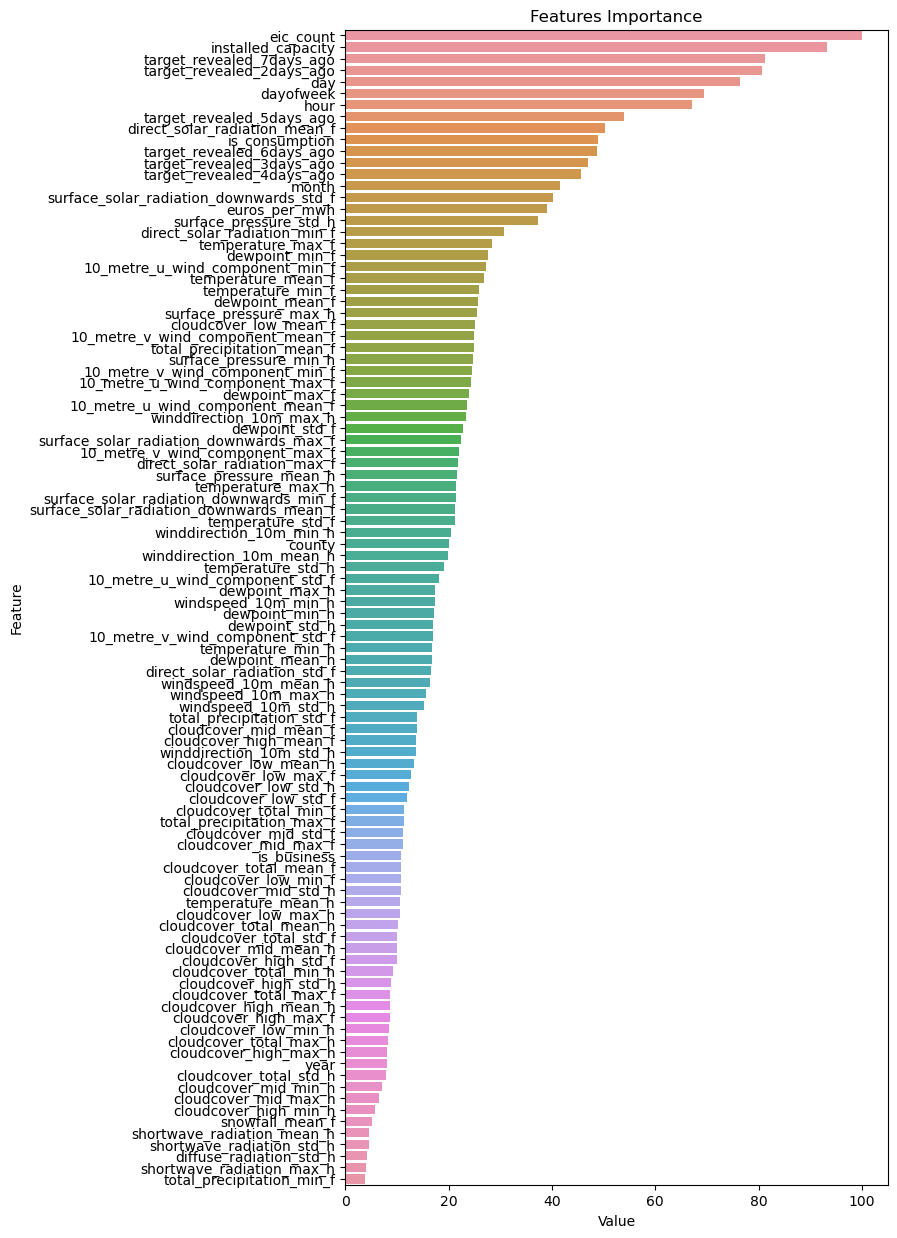

In [48]:
if len(Feature_Imp) > 90 : plt.figure(figsize=(7, 15))
elif len(Feature_Imp) > 60 : plt.figure(figsize=(7, 12))
elif len(Feature_Imp) > 30 : plt.figure(figsize=(7, 10))
else :
    plt.figure(figsize=(5, 5))
sns.barplot(x="Value", y="Feature", data=Feature_Imp.head(100))
plt.title('Features Importance')
plt.show()

In [49]:
Feature_Imp.Feature.tolist()[:20]

['eic_count',
 'installed_capacity',
 'target_revealed_7days_ago',
 'target_revealed_2days_ago',
 'day',
 'dayofweek',
 'hour',
 'target_revealed_5days_ago',
 'direct_solar_radiation_mean_f',
 'is_consumption',
 'target_revealed_6days_ago',
 'target_revealed_3days_ago',
 'target_revealed_4days_ago',
 'month',
 'surface_solar_radiation_downwards_std_f',
 'euros_per_mwh',
 'surface_pressure_std_h',
 'direct_solar_radiation_min_f',
 'temperature_max_f',
 'dewpoint_min_f']

In [50]:
Feature_Imp.Feature.tolist()[::-1][:10]

['highest_price_per_mwh_y',
 'lowest_price_per_mwh_y',
 'lowest_price_per_mwh_x',
 'highest_price_per_mwh_x',
 'rain_max_h',
 'snowfall_std_h',
 'direct_solar_radiation_min_h',
 'direct_solar_radiation_mean_h',
 'direct_solar_radiation_std_h',
 'direct_solar_radiation_max_h']